In [1]:

# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# For reproducibility
np.random.seed(42)


# Synthetic PV Dataset Generation

This notebook generates a high-fidelity synthetic dataset for MPPT training.
It includes:

- Solar irradiance with partial shading
- Ambient and PV cell temperature
- PV parameters: Voc, Isc, Vmp, Imp, Pmp
- MPPT duty cycle for buck converter

The dataset can later be used for:

- Static ML model training (non-time-series)
- RNN/LSTM time-series MPPT model


In [2]:
# Dataset parameters
num_samples = 50000          # Total data points
V_bus_nom = 400.0            # DC bus voltage for duty cycle calculation
Isc_ref = 9.0                # Short-circuit current at STC (A)
Voc_ref = 37.0               # Open-circuit voltage at STC (V)
Vmp_ref = 32.0               # Voltage at MPP at STC (V)
Imp_ref = 5.7                # Current at MPP at STC (A)
G_ref = 1000.0               # Reference irradiance (W/m²)
T_ref = 25.0                 # Reference temperature (C)
NOCT = 45.0                  # Nominal operating cell temperature
Kv = -0.12                   # Voc temperature coefficient (V/C)


In [3]:
t = np.arange(num_samples)                # time index
hours = (t / 3600) % 24                   # hours in day

# Clear-sky irradiance curve (sine wave)
G_clear = 1000 * np.maximum(0, np.sin((np.pi/12)*(hours-6)))

# Cloud fluctuations + Gaussian noise
G_noise = G_clear + np.random.normal(0, 30, size=num_samples)
G_noise = np.clip(G_noise, 0, None)

# Ambient temperature profile + small noise
T_amb = 25 + 5*np.sin((np.pi/12)*(hours-6)) + np.random.normal(0, 1, num_samples)


In [4]:
# Initialize shade factor = 1.0
shade_factor = np.ones(num_samples)

# Random shading events
num_shade_events = 200
for _ in range(num_shade_events):
    start = np.random.randint(0, num_samples-300)
    duration = np.random.randint(10, 300)
    factor = np.random.uniform(0.2, 0.8)
    shade_factor[start:start+duration] *= factor

# Effective irradiance
G_effective = G_noise * shade_factor


In [5]:
T_cell = T_amb + (NOCT - 20)/800 * G_effective


In [6]:
# Short-circuit current with noise
Isc = Isc_ref * (G_effective / G_ref) + np.random.normal(0, 0.05, size=num_samples)

# Open-circuit voltage with noise
Voc = Voc_ref + Kv * (T_cell - T_ref) + np.random.normal(0, 0.2, size=num_samples)

# Vmp, Imp with slight random variation
Vmp = Vmp_ref * (Voc / Voc_ref) + np.random.normal(0, 0.5, size=num_samples)
Imp = Imp_ref * (Isc / Isc_ref) + np.random.normal(0, 0.05, size=num_samples)

# Maximum power
Pmp = Vmp * Imp


In [7]:
duty_cycle = np.clip(Vmp / V_bus_nom + np.random.normal(0, 0.005, size=num_samples), 0.05, 0.95)


In [8]:
df = pd.DataFrame({
    'time': t,
    'G': G_noise,
    'T_amb': T_amb,
    'shade_factor': shade_factor,
    'G_effective': G_effective,
    'T_cell': T_cell,
    'Isc': Isc,
    'Voc': Voc,
    'Vmp': Vmp,
    'Imp': Imp,
    'Pmp': Pmp,
    'duty_cycle': duty_cycle
})

df.head()


,time,G,T_amb,shade_factor,G_effective,T_cell,Isc,Voc,Vmp,Imp,Pmp,duty_cycle
0,0,14.901425,20.098206,1.0,14.901425,20.563876,0.166985,37.481102,32.021273,0.211475,6.771703,0.088070
1,1,0.000000,19.935892,1.0,0.000000,19.935892,0.048731,37.855028,33.893922,0.050862,1.723921,0.088825
2,2,19.430656,20.951791,1.0,19.430656,21.558999,0.198592,37.244653,31.933608,0.168887,5.393181,0.084419
3,3,45.690896,21.532831,1.0,45.690896,22.960672,0.380580,36.807346,32.065555,0.354455,11.365791,0.079736
4,4,0.000000,20.686847,1.0,0.000000,20.686847,-0.019322,37.417665,31.669831,-0.017939,-0.568114,0.079597


In [9]:
df.to_csv('pv_mppt_dataset_noisy.csv', index=False)
print("Dataset saved as pv_mppt_dataset_noisy.csv")


Dataset saved as pv_mppt_dataset_noisy.csv


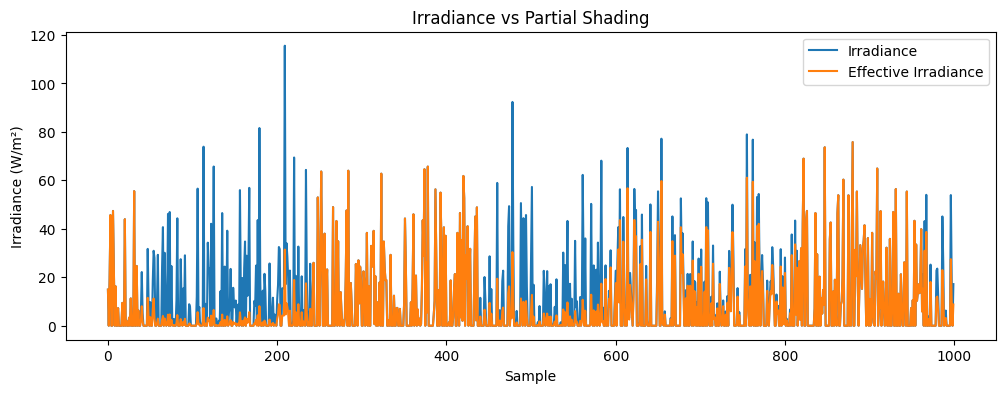

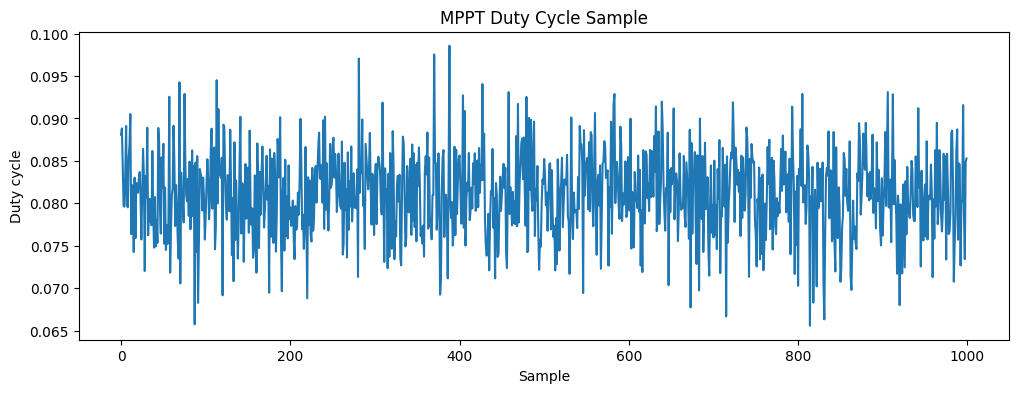

In [10]:
plt.figure(figsize=(12,4))
plt.plot(df['G'][:1000], label='Irradiance')
plt.plot(df['G_effective'][:1000], label='Effective Irradiance')
plt.xlabel('Sample')
plt.ylabel('Irradiance (W/m²)')
plt.legend()
plt.title('Irradiance vs Partial Shading')
plt.show()

plt.figure(figsize=(12,4))
plt.plot(df['duty_cycle'][:1000], label='Duty cycle')
plt.xlabel('Sample')
plt.ylabel('Duty cycle')
plt.title('MPPT Duty Cycle Sample')
plt.show()
